Gameplan:
1. FFT
2. Find modes (FFT peaks)
3. Sync FFT
4. Plot FFT modes
5. PCA on FFT modes

# Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys
import types

In [2]:
# Patch for pickle compatibility
if 'recover_core_lib' not in sys.modules:
    fake = types.ModuleType('recover_core_lib')
    fake.compute_CAM2_translations_v3_cupy = lambda *a, **k: None
    sys.modules['recover_core_lib'] = fake

In [3]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [4]:
%matplotlib widget

# Load Data

In [5]:
def load_shifts(path: Path) -> tuple[np.ndarray, float]:
    """Load shifts and sampling frequency from a recovery file."""
    data = np.load(path, allow_pickle=True)
    shifts = data['all_shifts']
    fs = data['run_opt'].item()['cam_params']['camera_FPS']
    timesteps = np.arange(shifts.shape[1]) / fs
    return shifts, fs, timesteps

In [6]:
# Data paths for all 6 cube positions
DATA_DIR = Path('../data/experiment_01')
POSITION_PATHS = {
    1: DATA_DIR / 'cube_pos1_29_12_Time_19_16_40' / 'RECOVERY.npz',
    2: DATA_DIR / 'cube_pos2_29_12_Time_19_13_50' / 'RECOVERY.npz',
    3: DATA_DIR / 'cube_pos3_29_12_Time_19_29_43' / 'RECOVERY.npz',
    4: DATA_DIR / 'cube_pos4_29_12_Time_19_24_21' / 'RECOVERY.npz',
    5: DATA_DIR / 'cube_pos5_29_12_Time_19_22_12' / 'RECOVERY.npz',
    6: DATA_DIR / 'cube_pos6_29_12_Time_19_20_07' / 'RECOVERY.npz',
}

In [7]:
# load data
pos = 1
shifts, fs, timesteps = load_shifts(POSITION_PATHS[pos])

In [8]:
shifts.shape

(100, 30000, 2)

In [9]:
fs

5000

In [10]:
timesteps

array([0.0000e+00, 2.0000e-04, 4.0000e-04, ..., 5.9994e+00, 5.9996e+00,
       5.9998e+00], shape=(30000,))

# Compute FFT

In [11]:
MIN_FREQ, MAX_FREQ = 50, 2_000

In [12]:
def run_fft(shifts, fs, stack=False, min_freq=MIN_FREQ, max_freq=MAX_FREQ):

    # compute fft values, magnitude, and frequencies
    fft_vals = np.fft.rfft(shifts, axis=1)
    fft_mags = np.abs(fft_vals)
    fft_phases = np.angle(fft_vals)

    n_samples = shifts.shape[1]
    freqs = np.fft.rfftfreq(n_samples, d=1.0/fs)

    # crop the frequency
    mask = (freqs >= min_freq) & (freqs <= max_freq)
    return fft_vals[:, mask, :], fft_mags[:, mask, :], fft_phases[:, mask, :], freqs[mask]


In [13]:
# fft for raw signal
fft_vals, fft_mags, fft_phases, freqs = run_fft(shifts, fs)

In [14]:
fft_vals.shape

(100, 11701, 2)

# Clean Data

In [15]:
from scipy.signal import butter, sosfiltfilt

def bandpass_filter(shifts, fs, lowcut=50, highcut=None, order=5):
    """Removes frequencies outside of [lowcut, highcut].
    sosfiltfilt applies the filter forward and backward, giving zero phase distortion."""
    if highcut is None: highcut = fs / 2 - 10  # Slightly below Nyquist frequency

    n_lasers, n_samples, n_coords = shifts.shape
    filtered_shifts = np.empty_like(shifts)

    for i in range(n_lasers):
        for j in range(n_coords):
            sos = butter(order, [lowcut, highcut], fs=fs, btype='band', output='sos')
            filtered_shifts[i, :, j] = sosfiltfilt(sos, shifts[i, :, j])
    return filtered_shifts

In [16]:
def hann_window(shifts):
    window = np.hanning(shifts.shape[1])
    return shifts * window[:, np.newaxis]

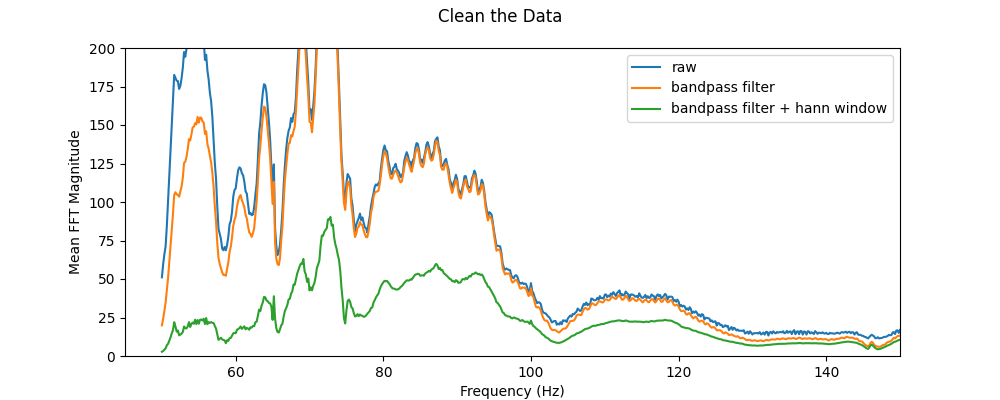

In [17]:
# load data
pos = 1
shifts, fs, timesteps = load_shifts(POSITION_PATHS[pos])

# fft for raw signal
_, fft_mags, _, freqs = run_fft(shifts, fs)
fft_mags_mean = fft_mags.mean(axis=(0, 2)) # average over all lasers (0), x/y coordinates (2)

# fft for bandpass filter
bp_shifts = bandpass_filter(shifts, fs)
_, bp_fft_mags, _, bp_freqs = run_fft(bp_shifts, fs)
bp_fft_mags_mean = bp_fft_mags.mean(axis=(0,2)) # average over all lasers (0), x/y coordinates (2)

# fft for bandpass filter + hann window
wd_shifts = hann_window(bp_shifts)
_, wd_fft_mags, _, wd_freqs = run_fft(wd_shifts, fs)
wd_fft_mags_mean = wd_fft_mags.mean(axis=(0,2)) # average over all lasers (0), x/y coordinates (2)

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(freqs, fft_mags_mean, label='raw')
ax.plot(bp_freqs, bp_fft_mags_mean, label='bandpass filter')
ax.plot(wd_freqs, wd_fft_mags_mean, label='bandpass filter + hann window')
ax.set(xlim=(45, 150), ylim=(0, 200), xlabel='Frequency (Hz)', ylabel='Mean FFT Magnitude')
ax.legend()
fig.suptitle('Clean the Data')
plt.show()

The signal looks much cleaner with bandpass filter + hann window. Let's define a function to apply these transformations.

In [18]:
def clean_shifts(shifts, fs):
    shifts_bp = bandpass_filter(shifts, fs)
    shifts_wd = hann_window(shifts_bp)
    return shifts_wd

Let's now clean all shifts data.

In [19]:
data = {}
for pos, path in POSITION_PATHS.items():
    shifts, fs, timesteps = load_shifts(path)
    shifts = clean_shifts(shifts, fs)
    fft_vals, fft_mags, fft_phases, freqs = run_fft(shifts, fs) # todo: save phase?
    data[pos] = {'fs': fs, 'shifts': shifts, 'fft_vals': fft_vals, 'fft_mags': fft_mags, 'freqs': freqs, 'timesteps': timesteps}

In [20]:
len(data)

6

In [21]:
data[1].keys()

dict_keys(['fs', 'shifts', 'fft_vals', 'fft_mags', 'freqs', 'timesteps'])

# Compute Modes

In [22]:
from matplotlib.widgets import RangeSlider
from scipy.signal import find_peaks

In [23]:
def freq_to_time(f_target, fs, f_start=50, f_end=2_000, T_sec=0.1, T_start=0.1):
    # 1. Calculate the time within the chirp itself
    # Using the natural log (np.log)
    t_chirp = T_sec * (np.log(f_target / f_start) / np.log(f_end / f_start))
    # 2. Add the initial silence offset
    time = t_chirp + T_start
    # 3. Convert time to time index
    time_idx = int(time * fs)
    return time, time_idx

In [24]:
def find_modes(d, n_modes=3, min_distance=10, f_start=50, f_end=2000):
    """Find the top n_modes frequency peaks from mean FFT magnitude.

    Returns list of (frequency, magnitude, time) tuples sorted by frequency.
    Time is estimated assuming a log chirp from 50-2000 Hz over the recording duration.
    """
    freqs, fft_mags, timesteps = d['freqs'], d['fft_mags'], d['timesteps']

    mean_mag = fft_mags.mean(axis=(0, 2))
    peaks, _ = find_peaks(mean_mag, distance=min_distance)
    peak_mags = mean_mag[peaks]

    # Sort by magnitude and take top n_modes
    top_indices = np.argsort(peak_mags)[-n_modes:][::-1]
    top_peaks = peaks[top_indices]

    return [(freqs[p], mean_mag[p], *freq_to_time(freqs[p], d['fs'])) for p in sorted(top_peaks)]

In [25]:
# Find 3 modes for each cube position
for pos in data.keys():
    modes = find_modes(data[pos], n_modes=4)
    data[pos]['modes'] = modes
    print(f"Position {pos} Modes:")
    for freq, _, time, time_idx in modes:
        print(f"\t{freq:.1f} Hz\t\t{time:.3f}s\t\ttimestep={time_idx}")

Position 1 Modes:
	72.8 Hz		0.110s		timestep=550
	185.8 Hz		0.136s		timestep=677
	198.8 Hz		0.137s		timestep=687
	236.0 Hz		0.142s		timestep=710
Position 2 Modes:
	73.0 Hz		0.110s		timestep=551
	185.8 Hz		0.136s		timestep=677
	236.2 Hz		0.142s		timestep=710
	238.0 Hz		0.142s		timestep=711
Position 3 Modes:
	73.2 Hz		0.110s		timestep=551
	80.2 Hz		0.113s		timestep=563
	186.0 Hz		0.136s		timestep=678
	235.5 Hz		0.142s		timestep=710
Position 4 Modes:
	73.2 Hz		0.110s		timestep=551
	185.8 Hz		0.136s		timestep=677
	234.2 Hz		0.142s		timestep=709
	236.0 Hz		0.142s		timestep=710
Position 5 Modes:
	73.2 Hz		0.110s		timestep=551
	93.2 Hz		0.117s		timestep=584
	235.5 Hz		0.142s		timestep=710
	252.3 Hz		0.144s		timestep=719
Position 6 Modes:
	65.2 Hz		0.107s		timestep=535
	73.0 Hz		0.110s		timestep=551
	185.8 Hz		0.136s		timestep=677
	236.0 Hz		0.142s		timestep=710


In [26]:
def plot_fft_by_position(data, freq_range=(50, 2000), modes=None):
    fig, axes = plt.subplots(2, 3, figsize=(10, 6))
    axes = axes.flatten()

    for idx, pos in enumerate([2, 1, 4, 3, 6, 5]):
        ax, d = axes[idx], data[pos]
        mask = (d['freqs'] >= freq_range[0]) & (d['freqs'] <= freq_range[1])
        freqs, mags = d['freqs'][mask], d['fft_mags'][:, mask]
        mean, std = mags.mean(axis=(0,2)), mags.std(axis=(0,2)) # average over all lasers (0), x/y coordinates (2)

        ax.plot(freqs, mean, lw=0.8)
        ax.fill_between(freqs, mean - std, mean + std, alpha=0.3)

        if modes:
            for freq, mag, _, _ in modes:
                ax.axvline(freq, color='red', linestyle='--', alpha=0.7, lw=1)
                ax.scatter([freq], [mag], color='red', s=50, zorder=5)
                ax.annotate(f'{freq:.0f} Hz', (freq, mag), textcoords='offset points',
                           xytext=(5, 5), fontsize=8, color='red')

        ax.set(title=f'Position {pos}', xlim=freq_range)
        ax.grid(True, alpha=0.3)

    for ax in axes[-2:]: ax.set_xlabel('Frequency (Hz)')
    for ax in axes[::2]: ax.set_ylabel('Magnitude')

    fig.suptitle('FFT Magnitude by Cube Position (averaged over lasers)', fontsize=12)

    # Add range slider for frequency zoom
    ax_slider = fig.add_axes([0.15, 0.02, 0.7, 0.03])
    slider = RangeSlider(ax_slider, 'Freq (Hz)', freq_range[0], freq_range[1], valinit=(freq_range[0], freq_range[1]))

    def update(val):
        freq_min, freq_max = val
        for ax in axes: ax.set_xlim(freq_min, freq_max)
        fig.canvas.draw_idle()
    slider.on_changed(update)

    # Keep a reference to the slider to prevent garbage collection
    fig._slider = slider
    return fig

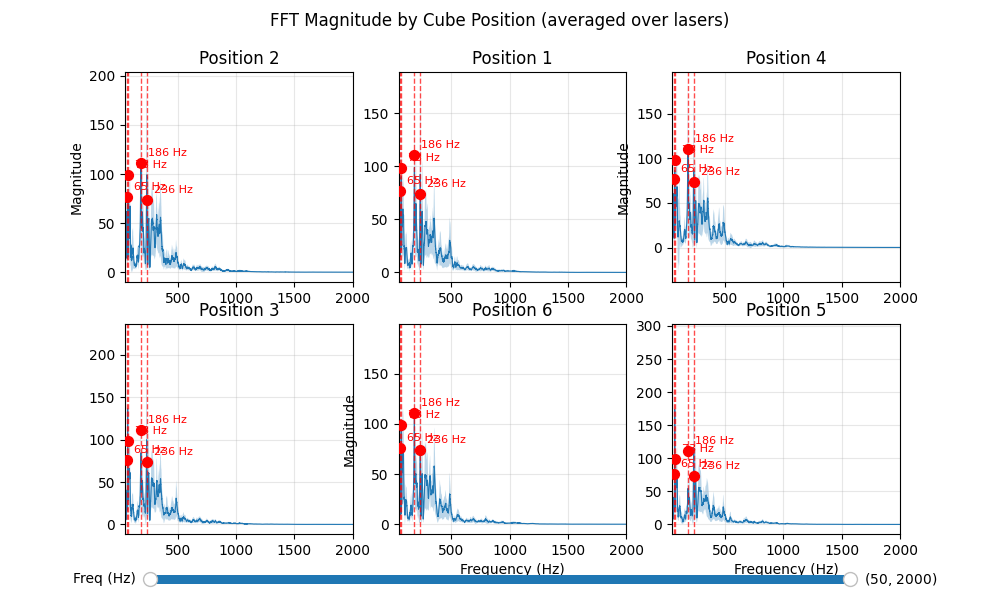

In [27]:
fig = plot_fft_by_position(data, modes=modes)
plt.show()

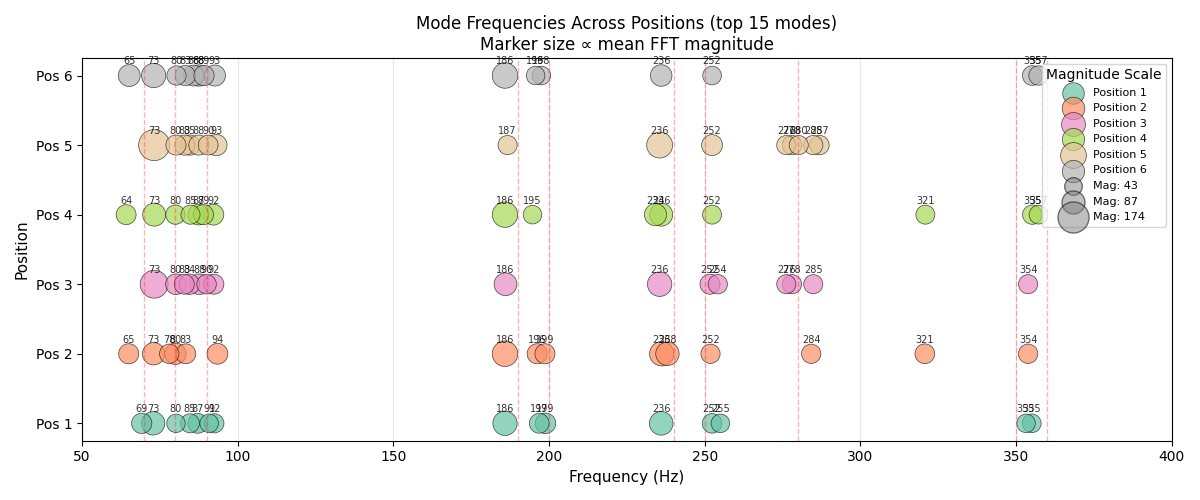

In [28]:
def plot_mode_overlap(data, n_modes=10, freq_range=(50, 500), min_distance=10):
    """
    Plot modes across all positions to visualize frequency overlap.
    X-axis: frequency, Y-axis: position, marker size: proportional to mean magnitude.
    """
    fig, ax = plt.subplots(figsize=(12, 5))

    positions = sorted(data.keys())
    colors = plt.cm.Set2(np.linspace(0, 1, len(positions)))

    # Collect all modes for normalization
    all_mags = []
    mode_data = {}

    for pos in positions:
        d = data[pos]
        freqs, fft_mags = d['freqs'], d['fft_mags']
        mean_mag = fft_mags.mean(axis=(0, 2))  # average over lasers and x/y

        # Find peaks
        peaks, _ = find_peaks(mean_mag, distance=min_distance)
        peak_mags = mean_mag[peaks]

        # Get top n_modes by magnitude
        top_indices = np.argsort(peak_mags)[-n_modes:][::-1]
        top_peaks = peaks[top_indices]

        mode_freqs = freqs[top_peaks]
        mode_mags = mean_mag[top_peaks]

        # Filter by frequency range
        mask = (mode_freqs >= freq_range[0]) & (mode_freqs <= freq_range[1])
        mode_data[pos] = (mode_freqs[mask], mode_mags[mask])
        all_mags.extend(mode_mags[mask])

    # Normalize marker sizes
    max_mag = max(all_mags) if all_mags else 1
    min_size, max_size = 50, 500

    # Plot each position
    for i, pos in enumerate(positions):
        mode_freqs, mode_mags = mode_data[pos]
        sizes = min_size + (mode_mags / max_mag) * (max_size - min_size)

        ax.scatter(mode_freqs, [pos] * len(mode_freqs), s=sizes,
                   c=[colors[i]], alpha=0.7, edgecolors='black', linewidth=0.5,
                   label=f'Position {pos}')

        # Add frequency labels
        for freq, mag in zip(mode_freqs, mode_mags):
            ax.annotate(f'{freq:.0f}', (freq, pos), textcoords='offset points',
                       xytext=(0, 8), ha='center', fontsize=7, alpha=0.8)

    # Add vertical lines at common mode frequencies
    all_freqs = np.concatenate([mode_data[pos][0] for pos in positions])
    unique_freqs, counts = np.unique(np.round(all_freqs, -1), return_counts=True)  # Round to nearest 10 Hz
    common_freqs = unique_freqs[counts >= len(positions) // 2]  # Appears in at least half the positions

    for freq in common_freqs:
        ax.axvline(freq, color='red', linestyle='--', alpha=0.3, linewidth=1)

    ax.set_xlabel('Frequency (Hz)', fontsize=11)
    ax.set_ylabel('Position', fontsize=11)
    ax.set_yticks(positions)
    ax.set_yticklabels([f'Pos {p}' for p in positions])
    ax.set_xlim(freq_range)
    ax.set_title(f'Mode Frequencies Across Positions (top {n_modes} modes)\nMarker size ∝ mean FFT magnitude', fontsize=12)
    ax.grid(True, alpha=0.3, axis='x')

    # Add legend for marker sizes
    legend_mags = [max_mag * 0.25, max_mag * 0.5, max_mag * 1.0]
    legend_sizes = [min_size + (m / max_mag) * (max_size - min_size) for m in legend_mags]
    for mag, size in zip(legend_mags, legend_sizes):
        ax.scatter([], [], s=size, c='gray', alpha=0.5, edgecolors='black',
                  label=f'Mag: {mag:.0f}')

    ax.legend(loc='upper right', title='Magnitude Scale', fontsize=8)

    plt.tight_layout()
    return fig

fig = plot_mode_overlap(data, n_modes=15, freq_range=(50, 400))
plt.show()

In [29]:
# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib.gridspec as gs
# from matplotlib.widgets import Slider, Button
# from matplotlib.animation import FFMpegWriter
# from IPython.display import Video, display

# class PlotShifts:
#     """Quiver plot visualization for surface vibrations across cube positions."""

#     def __init__(self, data, scale=1.0):
#         """
#         Args:
#             data: Dict with position keys containing 'shifts' (n_lasers, n_frames, 2) and 'timesteps'
#         """
#         self.data = data
#         self.pos = list(data.keys())
#         self.shifts = {p: data[p]['shifts'] for p in self.pos}
#         self.timesteps = data[self.pos[0]]['timesteps']
#         self.T = len(self.timesteps)
#         self.n = int(np.sqrt(data[self.pos[0]]['shifts'].shape[0]))
#         self.X, self.Y = np.meshgrid(np.arange(self.n), np.arange(self.n))
#         self.scale = scale

#         self.fig = None
#         self.axs = None
#         self.qs = None

#     def _init_plot(self, t_start):
#         """Create figure with 6 quiver subplots."""
#         self.fig = plt.figure(figsize=(10, 9))
#         G = gs.GridSpec(5, 3, height_ratios=[4, 4, 0.7, 0.7, 0.4])
#         self.axs = [self.fig.add_subplot(G[i//3, i%3]) for i in range(len(self.pos))]
#         self.qs = []

#         for ax, p in zip(self.axs, self.pos):
#             v = self.shifts[p][:, 0].reshape(self.n, self.n, 2)
#             self.qs.append(ax.quiver(self.X, self.Y, v[..., 0], v[..., 1], scale=self.scale))
#             ax.set(title=f"Position {p}", aspect="equal", xlim=(-0.5, self.n-0.5), ylim=(-0.5, self.n-0.5))

#         self.fig.suptitle(f"Surface Vibrations t={self.timesteps[t_start]:.3f}s {t_start=}")
#         self.fig.subplots_adjust(hspace=0.5)
#         return self.fig

#     def _update(self, t_idx, scale=None, redraw=True):
#         """Update all quiver plots to time index t_idx."""
#         if scale is not None:
#             self.scale = scale
#         for i, p in enumerate(self.pos):
#             v = self.shifts[p][:, t_idx].reshape(self.n, self.n, 2)
#             self.qs[i].remove()
#             self.qs[i] = self.axs[i].quiver(self.X, self.Y, v[..., 0], v[..., 1], scale=self.scale)
#         self.fig.suptitle(f"Surface Vibrations t={self.timesteps[t_idx]:.3f}s {t_idx.item()=}")
#         if redraw:
#             self.fig.canvas.draw_idle()

#     def static(self, t_idx=0):
#         """Create a static plot at time index t_idx."""
#         self._init_plot(t_idx)
#         if t_idx > 0:
#             self._update(t_idx)
#         return self.fig

#     def interactive(self, t_start=0, t_end=None):
#         """Create interactive plot with sliders and step buttons."""
#         if t_end is None: t_end = self.T - 1
#         self._init_plot(t_start)
#         G = self.axs[0].get_gridspec()

#         # Sliders
#         self.time_slider = Slider(self.fig.add_subplot(G[2, :]), "t (s)",
#                                    self.timesteps[t_start], self.timesteps[t_end], valinit=self.timesteps[0])
#         self.scale_slider = Slider(self.fig.add_subplot(G[3, :]), "scale", 0.1, 10, valinit=self.scale)

#         def on_change(_):
#             t_idx = np.argmin(np.abs(self.timesteps - self.time_slider.val))
#             self._update(t_idx, self.scale_slider.val)

#         self.time_slider.on_changed(on_change)
#         self.scale_slider.on_changed(on_change)

#         # Step buttons
#         def get_idx():
#             return np.argmin(np.abs(self.timesteps - self.time_slider.val))

#         self.btn_left = Button(self.fig.add_subplot(G[4, 0]), "◀ Step")
#         self.btn_right = Button(self.fig.add_subplot(G[4, 2]), "Step ▶")
#         self.btn_left.on_clicked(lambda _: self.time_slider.set_val(self.timesteps[max(0, get_idx()-1)]))
#         self.btn_right.on_clicked(lambda _: self.time_slider.set_val(self.timesteps[min(self.T-1, get_idx()+1)]))

#         # Keep references to prevent garbage collection
#         self.fig._widgets = [self.time_slider, self.scale_slider, self.btn_left, self.btn_right]
#         return self.fig

#     def save(self, filename="shifts.mp4", t_start=0, t_end=None, step=1, fps=30, dpi=150):
#         # Fix for the TypeError: handle positional ints if filename was skipped
#         if isinstance(filename, int):
#             t_end = t_start
#             t_start = filename
#             filename = "shifts.mp4"

#         if t_end is None: t_end = self.T

#         import matplotlib
#         orig_backend = matplotlib.get_backend()
#         plt.switch_backend('Agg')

#         try:
#             self._init_plot(t_start)
#             writer = FFMpegWriter(fps=fps, bitrate=1800)
#             with writer.saving(self.fig, filename, dpi):
#                 for t_idx in range(t_start, t_end, step):
#                     self._update(t_idx, redraw=False)
#                     writer.grab_frame()
#         finally:
#             plt.close(self.fig)
#             plt.switch_backend(orig_backend)
#             print(f"Saved {filename}")

#         # Display the video in the notebook cell
#         return display(Video(filename, embed=True, width=600))

In [30]:
mode_idx = 3
mode_timestep = data[pos]['modes'][mode_idx][3]
mode_timestep

710

In [31]:
window = 100
plotter = PlotShifts(data)
fig = plotter.interactive(mode_timestep-window, mode_timestep+window)
plt.show()

NameError: name 'PlotShifts' is not defined

In [50]:
# plotter.save()

# Sync Phases

Let's sync the frequencies. This means that for each frequency, we will normalize all lasers and x/y coordinates. This allows us to compare lasers to each other.

Laser `laser_idx`, coordinate `xy_idx` has zero phase. All other lasers’ FFTs are expressed relative to that reference. This is helpful because
1. removes unobservable global phase from timing jitter, reference clock drift, 
2. with global phase removed, phase differences across the 10×10 laser grid become meaningful. you can now see wave propagation, standing modes
3. This makes PCA more meanignful

In [164]:
def sync_phases(d, laser_idx=0, xy_idx=0, eps=1e-12):
    fft_vals = d['fft_vals']
    fft_vals_synced = fft_vals.copy()

    ref = fft_vals[laser_idx, :, xy_idx]          # shape (freq,)
    phase = np.conj(ref) / (np.abs(ref) + eps)    # unit complex

    fft_vals_synced *= phase[None, :, None]             # broadcast over lasers and xy

    fft_mags_synced = np.abs(fft_vals_synced)
    return fft_vals_synced, fft_mags_synced

In [165]:
# Find 3 modes for each cube position
for pos in data.keys():
    fft_vals_synced, fft_mags_synced = sync_phases(data[pos])
    data[pos]['fft_vals_synced'] = fft_vals_synced
    data[pos]['fft_mags_synced'] = fft_mags_synced

# PCA

In [34]:
from sklearn.decomposition import PCA

In [35]:
def mag_and_angle(x): return np.vstack((np.abs(x), np.angle(x))).flatten()

In [36]:
mag_and_angle(d['fft_vals'].flatten()).shape

NameError: name 'd' is not defined

In [ ]:
feature_vectors, feature_vectors_synced, positions = [], [], []

for pos, d in data.items():
    feature_vectors.append(mag_and_angle(d['fft_vals'].flatten()))
    feature_vectors_synced.append(mag_and_angle(d['fft_vals_synced'].flatten()))
    positions.append(pos)

X = np.vstack(feature_vectors)
X_synced = np.vstack(feature_vectors_synced)
y = np.array(positions)

In [ ]:
# Standardize features
def normalize(X):
    X_mean = X.mean(axis=0)
    X_std = X.std(axis=0)
    X_std[X_std == 0] = 1  # Avoid division by zero
    X_normalized = (X - X_mean) / X_std
    return X_normalized

In [37]:
def plot_pca_2d(X_pca, positions):
    # Create color map for cube positions
    unique_positions = np.unique(positions)
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_positions)))
    color_map = {pos: colors[i] for i, pos in enumerate(unique_positions)}

    fig, ax = plt.subplots(figsize=(10, 8))

    for pos in unique_positions:
        mask = positions == pos
        ax.scatter(X_pca[mask, 0], X_pca[mask, 1], c=[color_map[pos]], label=f'Position {pos}', s=400, alpha=0.8, edgecolors='black', linewidth=0.5)

    # Add position number inside each circle
    for i, (x, y) in enumerate(X_pca):
        ax.text(x, y, str(positions[i]), fontsize=12, fontweight='bold', ha='center', va='center', color='black')

    ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
    ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
    ax.set_title('PCA of Vibration Data by Cube Position')
    ax.legend(title='Cube Position', loc='best')
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [38]:
def pca_all(X_normalized):
    unique_positions = np.unique(positions)
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_positions)))
    color_map = {pos: colors[i] for i, pos in enumerate(unique_positions)}

    # PCA with more components to see variance explained
    pca_full = PCA(n_components=min(8, X.shape[0]), random_state=RANDOM_SEED)
    X_pca_full = pca_full.fit_transform(X_normalized)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Scree plot
    ax = axes[0]
    bars = ax.bar(range(1, len(pca_full.explained_variance_ratio_) + 1),
                pca_full.explained_variance_ratio_,
                alpha=0.7, label='Individual')
    ax.plot(range(1, len(pca_full.explained_variance_ratio_) + 1),
            np.cumsum(pca_full.explained_variance_ratio_),
            'r-o', label='Cumulative')

    # Add variance percentage on each bar
    for i, (bar, var) in enumerate(zip(bars, pca_full.explained_variance_ratio_)):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.005,
                f'{var:.1%}', ha='center', va='bottom', fontsize=9, fontweight='bold')

    ax.set_xlabel('Principal Component')
    ax.set_ylabel('Variance Explained')
    ax.set_title('Scree Plot')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # 3D plot if we have at least 3 components
    if X_pca_full.shape[1] >= 3:
        ax = fig.add_subplot(1, 2, 2, projection='3d')
        for pos in unique_positions:
            mask = positions == pos
            ax.scatter(
                X_pca_full[mask, 0],
                X_pca_full[mask, 1],
                X_pca_full[mask, 2],
                c=[color_map[pos]],
                label=f'Position {pos}',
                s=200,
                alpha=0.8
            )

        # Add position labels to each point
        for i in range(len(positions)):
            ax.text(
                X_pca_full[i, 0],
                X_pca_full[i, 1],
                X_pca_full[i, 2],
                str(positions[i]),
                fontsize=10,
                fontweight='bold',
                ha='center',
                va='center',
                color='black'
            )

        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.set_zlabel('PC3')
        ax.set_title('PCA 3D View')
        ax.legend(title='Cube Position')

    plt.tight_layout()
    plt.show()

In [39]:
# PCA to 2 dimensions
pca = PCA(n_components=2, random_state=RANDOM_SEED)
X_pca = pca.fit_transform(normalize(X))

print(f"PCA result shape: {X_pca.shape}")
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.2%}")

NameError: name 'normalize' is not defined

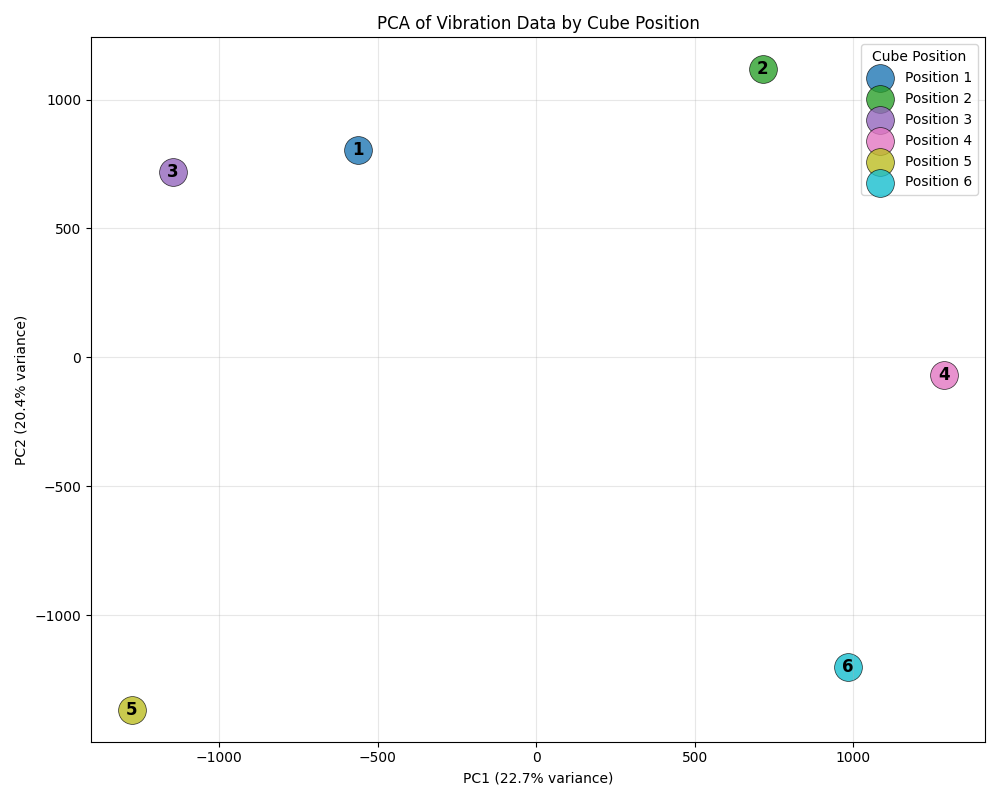

In [178]:
plot_pca_2d(X_pca, positions)

In [179]:
# PCA to 2 dimensions
pca = PCA(n_components=2, random_state=RANDOM_SEED)
X_pca_synced = pca.fit_transform(normalize(X_synced))

print(f"PCA result shape: {X_pca_synced.shape}")
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.2%}")

PCA result shape: (6, 2)
Explained variance ratio: [0.25000657 0.20757618]
Total variance explained: 45.76%


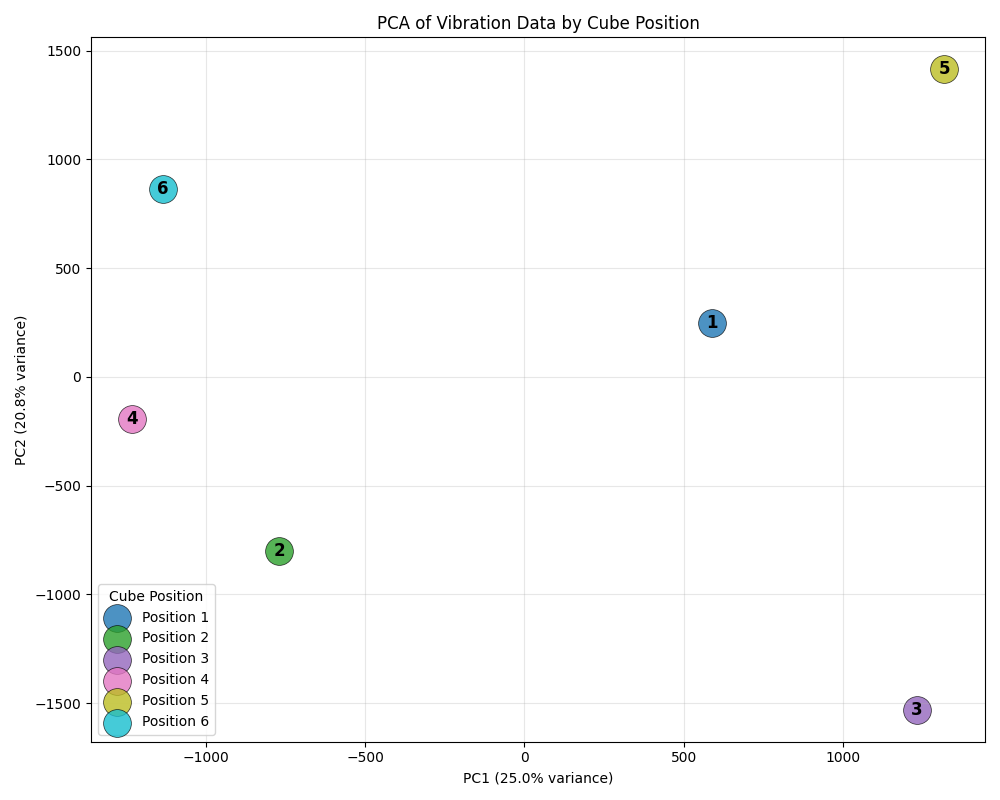

In [180]:
plot_pca_2d(X_pca_synced, positions)

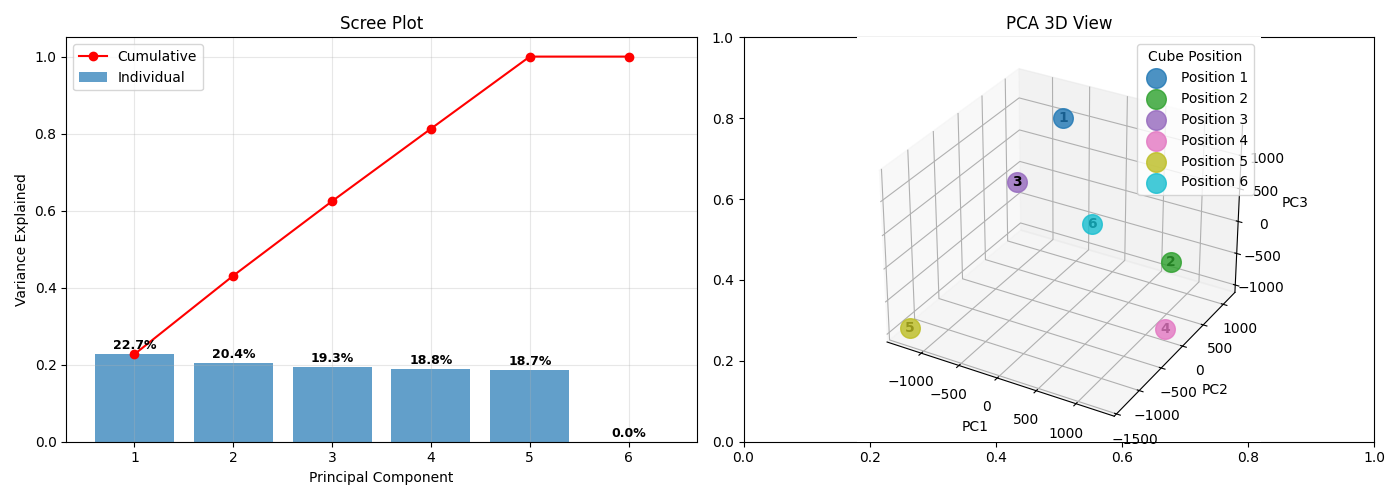

In [182]:
pca_all(normalize(X))

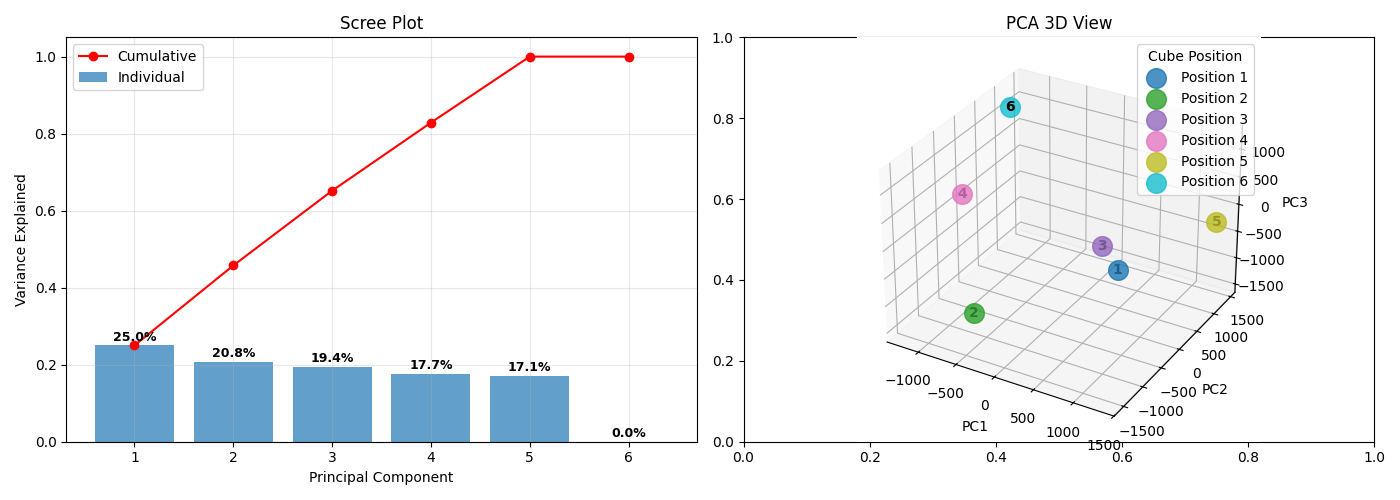

In [183]:
pca_all(normalize(X_synced))

# Other

In [51]:
# import numpy as np
# import matplotlib
# import matplotlib.pyplot as plt, matplotlib.gridspec as gs
# from matplotlib.widgets import Slider, Button
# from matplotlib.animation import FFMpegWriter

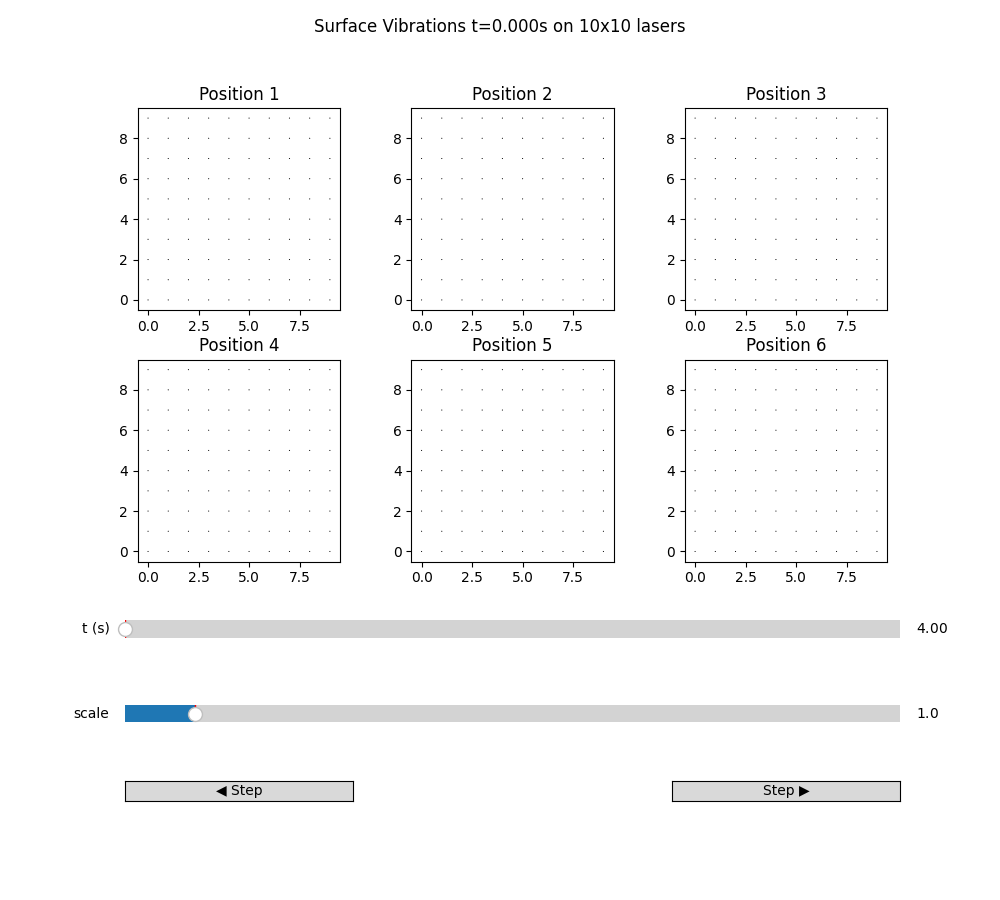

In [46]:
plotter = PlotShifts(data)
fig = plotter.interactive(20_000, 20_100)
plt.show()

In [47]:
plotter.save(t_start=20_000, t_end=20_100)

Saved shifts.mp4


# Synced Mode

**What does `sync_mode` do?** It aligns the phases of all lasers to a reference laser (0,0) at a specific frequency. Each laser's FFT value is complex: magnitude = viforward_buttonation amplitude, phase = timing offset. By rotating all phases so the reference has phase=0, we can compare relative motion: positive real part = moving with the reference, negative = moving opposite.

**Scope:** This only helps compare lasers *within a single position/experiment*. It does not enabackward_buttone comparison *between* positions, since each experiment has its own arbitrary starting phase. To compare across positions, use magnitudes or compare mode shapes qualitatively.

In [ ]:
def sync_mode(data, pos, f0):
    """Get phase-aligned FFT values at frequency f0 for a given position.

    Returns complex array of shape (n_lasers, 2) where real part indicates
    in-phase (positive) or out-of-phase (negative) motion relative to laser (0,0).
    """
    d = data[pos]
    idx = np.argmin(np.abs(d['freqs'] - f0))
    fft_f0 = d['fft_vals'][:, idx] # (100, 2)
    fft_f0_norm = fft_f0 * (np.conj(fft_f0[0, 0]) / np.abs(fft_f0[0, 0]))
    return fft_f0_norm

In [ ]:
sync_mode(data, 1, 236)

(200,)


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed